<a href="https://colab.research.google.com/github/LuccaRomagnolli/Neural-Networks-1-1/blob/main/Marketing_Banking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação Binária utilizando MLP e CNN (Deep Learning)

## autor: Lucca Maximus Romagnolli

### Os dados usados no projeto estão relacionados a campanhas de marketing direto (ligações telefônicas) de uma instituição bancária portuguesa. O objetivo da classificação é prever se o cliente irá subscrever um depósito a prazo (variável y).

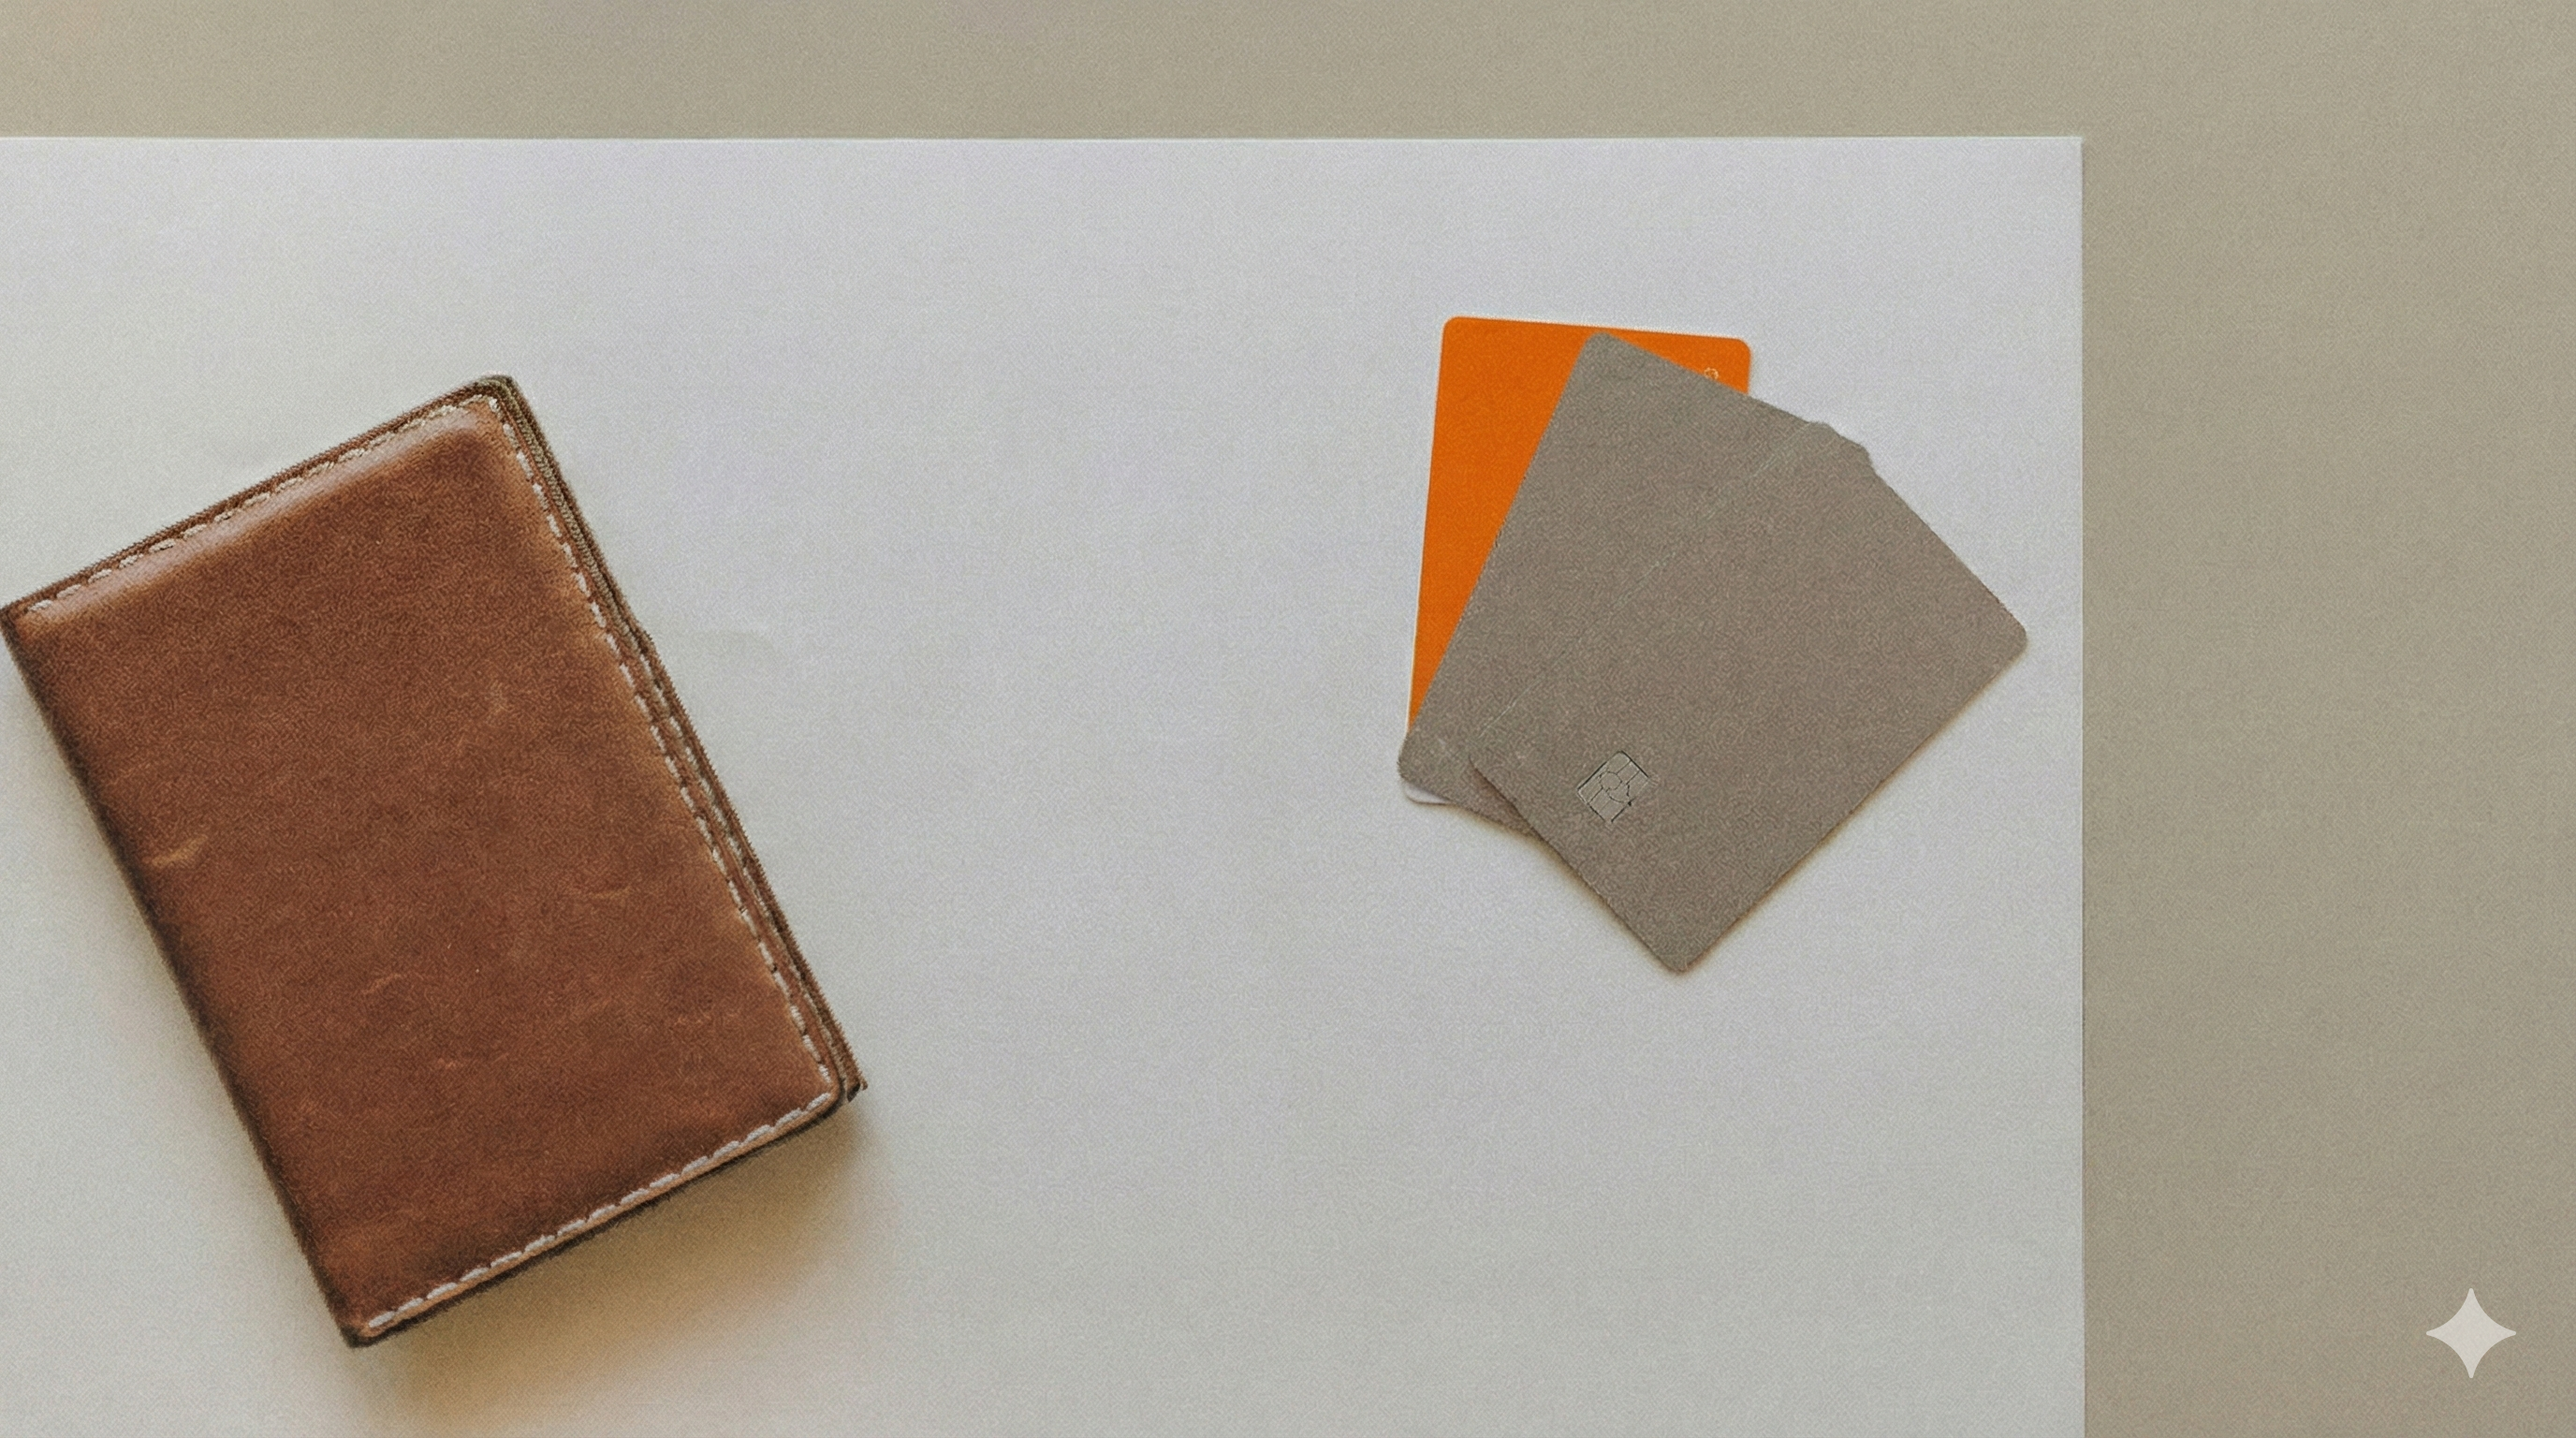

### Setup 🔽

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Reshape, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

### Data Dictionary 📖



Os dados estão relacionados a campanhas de marketing direto de uma instituição bancária portuguesa. As campanhas de marketing foram realizadas por meio de chamadas telefônicas. Frequentemente, mais de um contato com o mesmo cliente foi necessário para avaliar se o produto (depósito a prazo bancário) seria subscrito `(“sim”)` ou não `(“não”)`.


---
                                   Variáveis:

- **age**: Idade do cliente em anos (numérico)

- **job**: Tipo de ocupação (categórico: admin., blue-collar, entrepreneur, housemaid, management, retired, self-employed, services, student, technician, unemployed, unknown)

- **marital**: Estado civil (categórico: divorced, married, single, unknown; nota: divorced inclui viúvos)

- **education**: Nível de escolaridade (categórico: basic.4y, basic.6y, basic.9y, high.school, illiterate, professional.course, university.degree, unknown)

- **default**: Possui crédito em default? (categórico: no, yes, unknown)

- **housing**: Possui empréstimo imobiliário? (categórico: no, yes, unknown)

- **loan**: Possui empréstimo pessoal? (categórico: no, yes, unknown)

- **contact**: Tipo de comunicação do contato (categórico: cellular, telephone)

- **month**: Mês do último contato (categórico: jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec)

- **day_of_week**: Dia da semana do último contato (categórico: mon, tue, wed, thu, fri)

- **duration**: Duração do último contato em segundos (numérico) ⚠️ *Apenas para benchmark - não disponível antes da chamada*

- **campaign**: Número de contatos realizados durante esta campanha (numérico, inclui último contato)

- **pdays**: Dias desde o último contato da campanha anterior (numérico; 999 = não foi contactado anteriormente)

- **previous**: Número de contatos antes desta campanha (numérico)

- **poutcome**: Resultado da campanha anterior (categórico: failure, nonexistent, success)

- **emp.var.rate**: Taxa de variação do emprego - indicador trimestral (numérico)

- **cons.price.idx**: Índice de preços ao consumidor - indicador mensal (numérico)

- **cons.conf.idx**: Índice de confiança do consumidor - indicador mensal (numérico)

- **euribor3m**: Taxa Euribor de 3 meses - indicador diário (numérico)

- **nr.employed**: Número de empregados - indicador trimestral (numérico)

- **`y`**: O cliente subscreveu um depósito a prazo? (binário: yes, no)

### EDA 🆎

In [ ]:
# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

#### Análise de Assimetria SKEW

 **Implicações na escolha do modelo:**
- Alta assimetria	Árvores lidam melhor
 - Baixa assimetria	MLP / SVM se beneficiam
- Assimetria tratada	CNN 1D fica mais competitiva


---


| Valor | Nível de Assimetria |
|-----------|-------------------|
| \|skew\| < 0.5 | Baixa assimetria |
| 0.5 ≤ \|skew\| < 1 | Moderada assimetria |
| \|skew\| ≥ 1 | Alta assimetria |


In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

for col in numeric_cols:
    skew_val = df[col].skew()
    if abs(skew_val) < 0.5:
        interpretation = "aproximadamente simétrica"
    elif skew_val > 0.5:
        interpretation = "assimétrica à direita (positiva)"
    else:
        interpretation = "assimétrica à esquerda (negativa)"
    print(f"   • {col}: {skew_val:.3f} - {interpretation}")

   • age: 0.785 - assimétrica à direita (positiva)
   • duration: 3.263 - assimétrica à direita (positiva)
   • campaign: 4.763 - assimétrica à direita (positiva)
   • pdays: -4.922 - assimétrica à esquerda (negativa)
   • previous: 3.832 - assimétrica à direita (positiva)
   • emp.var.rate: -0.724 - assimétrica à esquerda (negativa)
   • cons.price.idx: -0.231 - aproximadamente simétrica
   • cons.conf.idx: 0.303 - aproximadamente simétrica
   • euribor3m: -0.709 - assimétrica à esquerda (negativa)
   • nr.employed: -1.044 - assimétrica à esquerda (negativa)


#### Análise de variável alvo



In [ ]:

target_counts = df['y'].value_counts()
target_pct = df['y'].value_counts(normalize=True) * 100

print(f"\nDISTRIBUIÇÃO DA VARIÁVEL TARGET:")
print(f"\n   Classe    | Contagem  | Percentual")
print(f"   " + "-"*40)
for idx, (value, count) in enumerate(target_counts.items()):
    print(f"   {value:9} | {count:9,} | {target_pct[value]:9.2f}%")

print(f"\nRAZÃO DE DESBALANCEAMENTO:")
ratio = target_counts.max() / target_counts.min()
print(f"   • Razão: {ratio:.2f}:1")

if ratio > 3:
    print(f"   Dataset DESBALANCEADO - Considere técnicas como:")
    print(f"      • SMOTE (Synthetic Minority Over-sampling)")
    print(f"      • Class weights")
    print(f"      • Undersampling da classe majoritária")
elif ratio > 1.5:
    print(f"   Leve desbalanceamento - Monitore as métricas de recall/precision")
else:
    print(f"   ✓ Dataset balanceado")


DISTRIBUIÇÃO DA VARIÁVEL TARGET:

   Classe    | Contagem  | Percentual
   ----------------------------------------
   no        |    36,548 |     88.73%
   yes       |     4,640 |     11.27%

RAZÃO DE DESBALANCEAMENTO:
   • Razão: 7.88:1
   Dataset DESBALANCEADO - Considere técnicas como:
      • SMOTE (Synthetic Minority Over-sampling)
      • Class weights
      • Undersampling da classe majoritária


#### Análise de Outliers

In [ ]:
print(f"\nDETECÇÃO DE OUTLIERS (Método IQR):")
print(f"\n   Variável                | Q1      | Q3      | IQR     | Outliers | % Outliers")
print(f"   " + "-"*90)

outlier_summary = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    n_outliers = len(outliers)
    pct_outliers = (n_outliers / len(df)) * 100

    outlier_summary[col] = {
        'n_outliers': n_outliers,
        'pct': pct_outliers
    }

    print(f"   {col:25} | {Q1:7.2f} | {Q3:7.2f} | {IQR:7.2f} | {n_outliers:8,} | {pct_outliers:9.2f}%")

# Resumo de outliers
total_outliers = sum([v['n_outliers'] for v in outlier_summary.values()])
print(f"\n   Total de outliers detectados: {total_outliers:,}")

high_outlier_vars = [k for k, v in outlier_summary.items() if v['pct'] > 5]
if high_outlier_vars:
    print(f"   Variáveis com >5% de outliers: {', '.join(high_outlier_vars)}")
    print(f"      Recomendação: Investigar e considerar transformação ou remoção")


DETECÇÃO DE OUTLIERS (Método IQR):

   Variável                | Q1      | Q3      | IQR     | Outliers | % Outliers
   ------------------------------------------------------------------------------------------
   age                       |   32.00 |   47.00 |   15.00 |      469 |      1.14%
   duration                  |  102.00 |  319.00 |  217.00 |    2,963 |      7.19%
   campaign                  |    1.00 |    3.00 |    2.00 |    2,406 |      5.84%
   pdays                     |  999.00 |  999.00 |    0.00 |    1,515 |      3.68%
   previous                  |    0.00 |    0.00 |    0.00 |    5,625 |     13.66%
   emp.var.rate              |   -1.80 |    1.40 |    3.20 |        0 |      0.00%
   cons.price.idx            |   93.08 |   93.99 |    0.92 |        0 |      0.00%
   cons.conf.idx             |  -42.70 |  -36.40 |    6.30 |      447 |      1.09%
   euribor3m                 |    1.34 |    4.96 |    3.62 |        0 |      0.00%
   nr.employed               | 5099.10 | 

#### Visualização Gráfica


9. GERANDO VISUALIZAÇÕES PROFISSIONAIS

✓ Visualizações salvas em 'eda_analysis_complete.png'


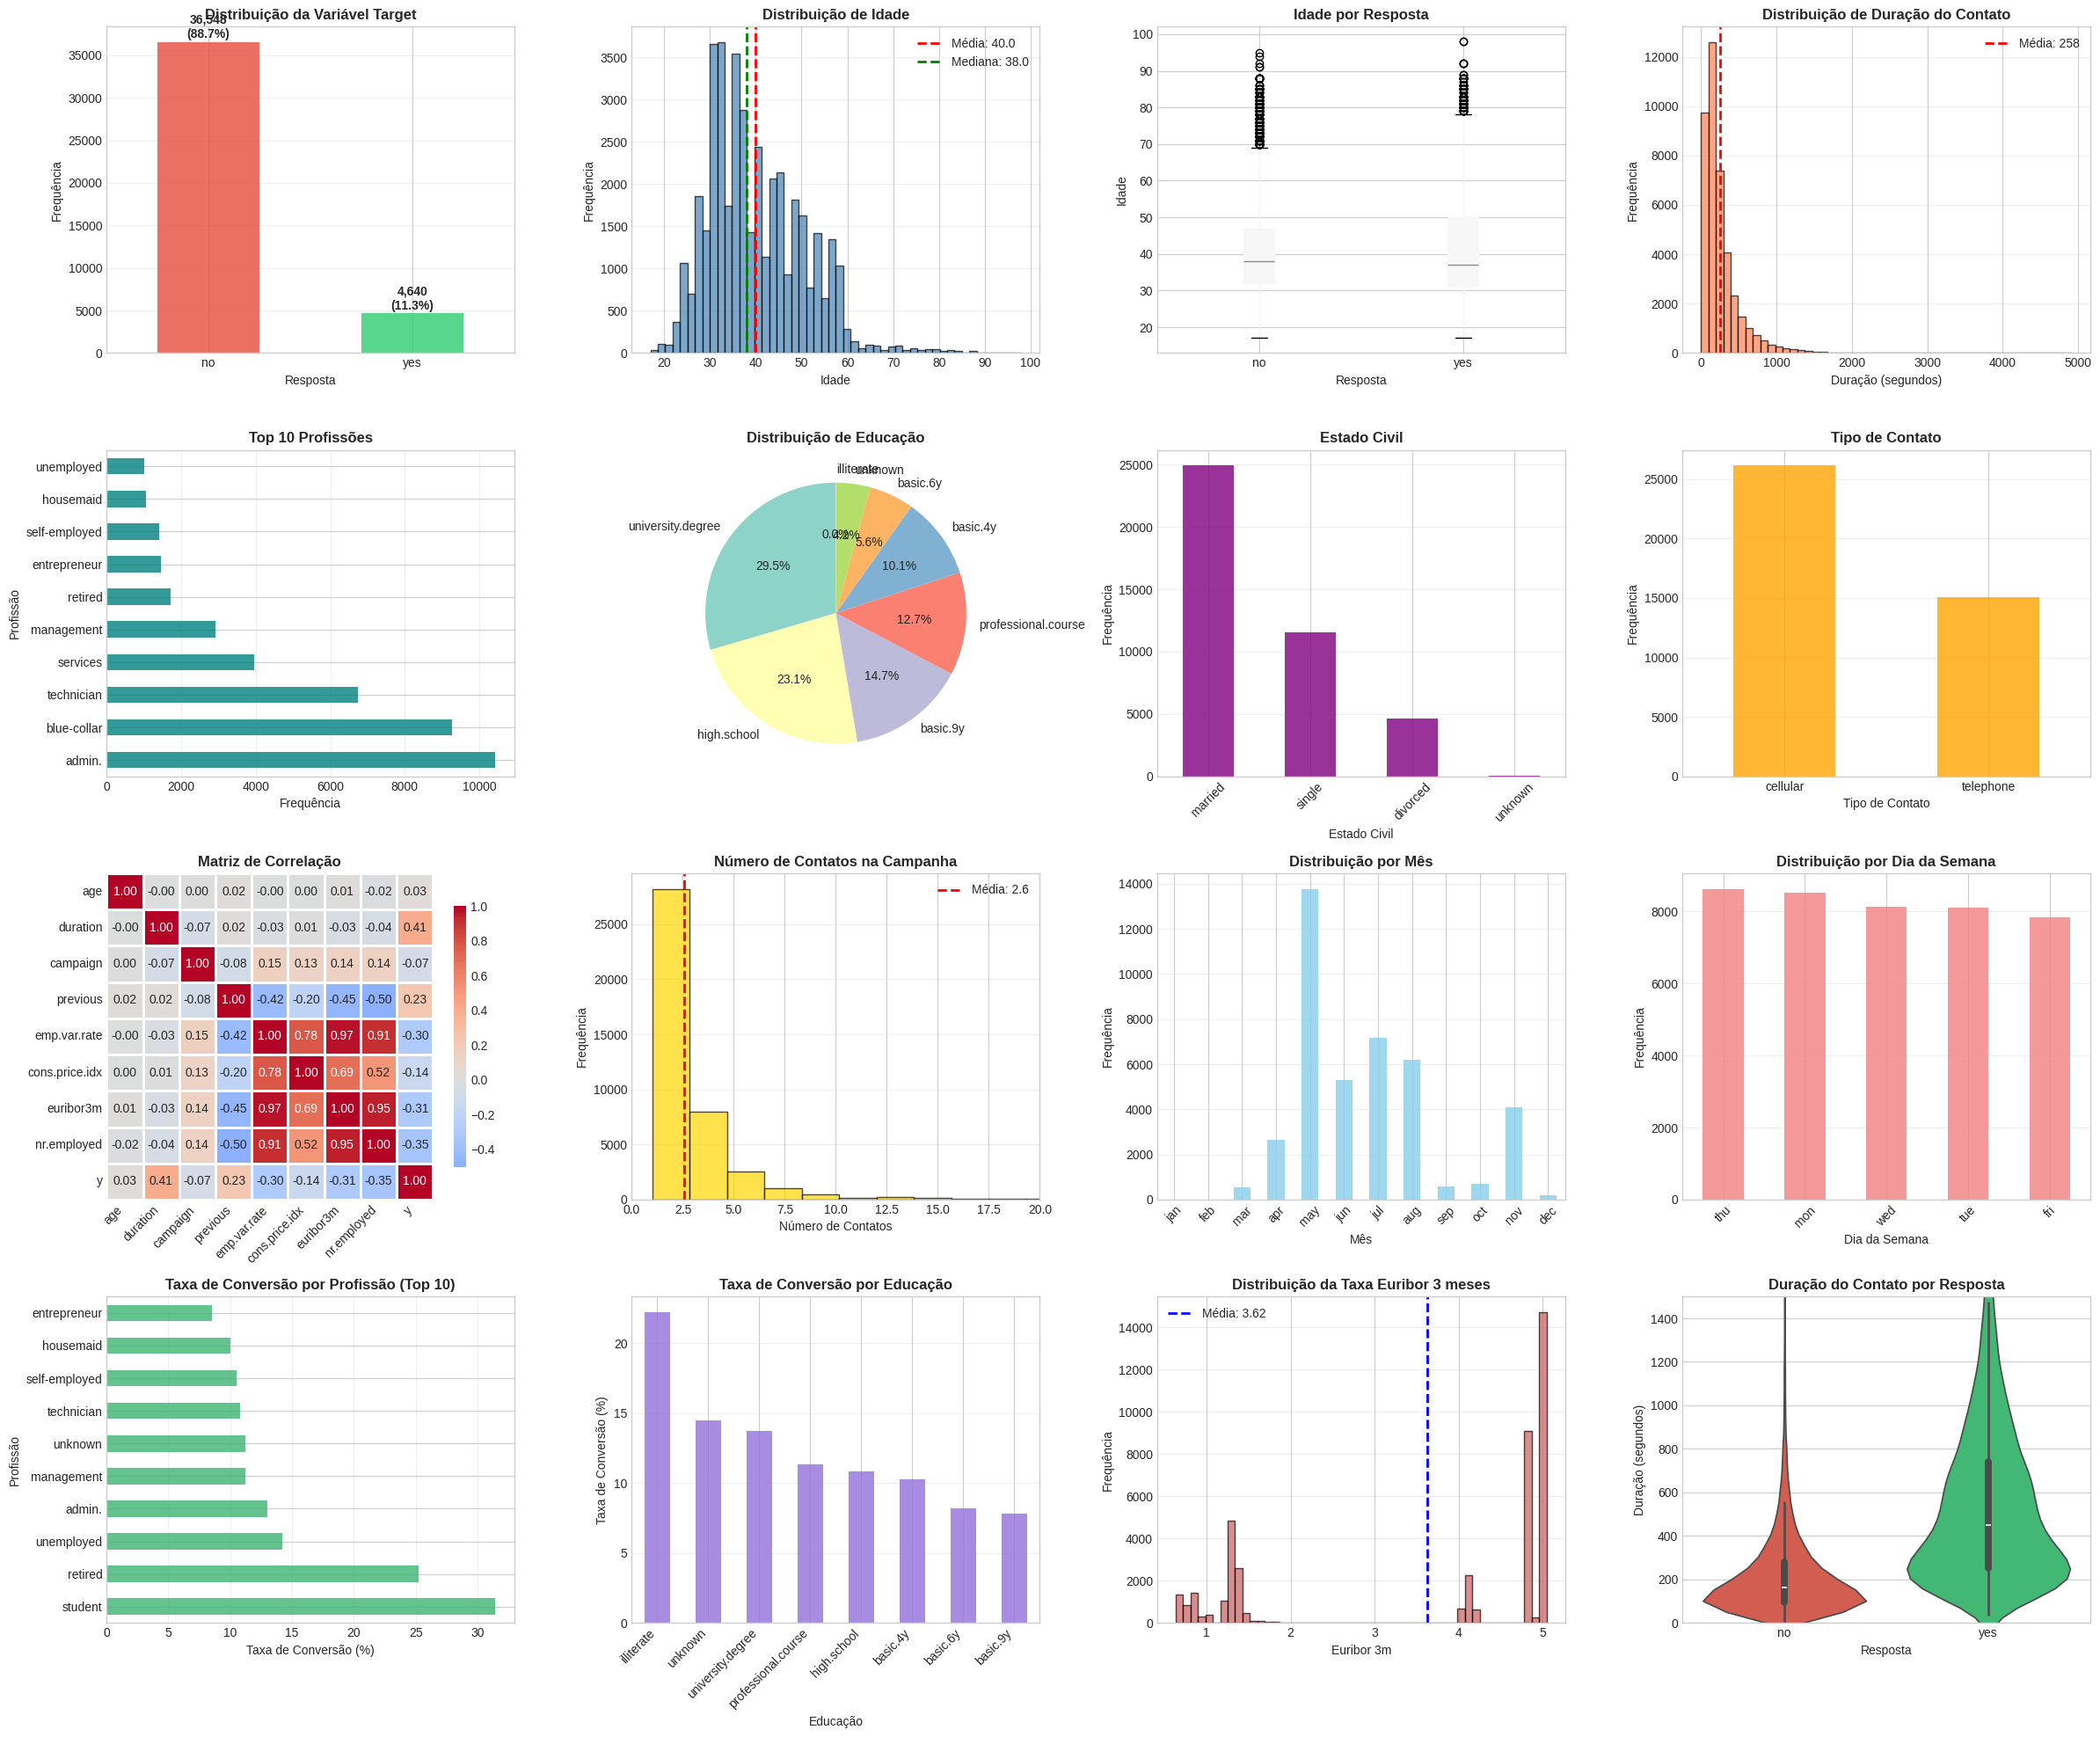

In [ ]:
# @title

# Criar figura com múltiplos subplots
fig = plt.figure(figsize=(24, 20))
fig.suptitle('ANÁLISE EXPLORATÓRIA DE DADOS - CAMPANHA BANCÁRIA',
             fontsize=20, fontweight='bold', y=0.995)

# 1. Distribuição do Target
ax1 = plt.subplot(4, 4, 1)
target_counts.plot(kind='bar', color=['#e74c3c', '#2ecc71'], alpha=0.8)
plt.title('Distribuição da Variável Target', fontsize=12, fontweight='bold')
plt.xlabel('Resposta')
plt.ylabel('Frequência')
plt.xticks(rotation=0)
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 500, f'{v:,}\n({target_pct.values[i]:.1f}%)',
             ha='center', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# 2. Distribuição de Idade
ax2 = plt.subplot(4, 4, 2)
plt.hist(df['age'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.axvline(df['age'].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {df["age"].mean():.1f}')
plt.axvline(df['age'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df["age"].median():.1f}')
plt.title('Distribuição de Idade', fontsize=12, fontweight='bold')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 3. Boxplot de Idade por Target
ax3 = plt.subplot(4, 4, 3)
df.boxplot(column='age', by='y', ax=ax3, patch_artist=True)
plt.title('Idade por Resposta', fontsize=12, fontweight='bold')
plt.suptitle('')
plt.xlabel('Resposta')
plt.ylabel('Idade')

# 4. Distribuição de Duration
ax4 = plt.subplot(4, 4, 4)
plt.hist(df['duration'], bins=50, color='coral', alpha=0.7, edgecolor='black')
plt.axvline(df['duration'].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {df["duration"].mean():.0f}')
plt.title('Distribuição de Duração do Contato', fontsize=12, fontweight='bold')
plt.xlabel('Duração (segundos)')
plt.ylabel('Frequência')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 5. Top 10 Profissões
ax5 = plt.subplot(4, 4, 5)
top_jobs = df['job'].value_counts().head(10)
top_jobs.plot(kind='barh', color='teal', alpha=0.8)
plt.title('Top 10 Profissões', fontsize=12, fontweight='bold')
plt.xlabel('Frequência')
plt.ylabel('Profissão')
plt.grid(axis='x', alpha=0.3)

# 6. Educação
ax6 = plt.subplot(4, 4, 6)
education_counts = df['education'].value_counts()
colors_edu = plt.cm.Set3(range(len(education_counts)))
plt.pie(education_counts.values, labels=education_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors_edu)
plt.title('Distribuição de Educação', fontsize=12, fontweight='bold')

# 7. Estado Civil
ax7 = plt.subplot(4, 4, 7)
marital_counts = df['marital'].value_counts()
marital_counts.plot(kind='bar', color='purple', alpha=0.8)
plt.title('Estado Civil', fontsize=12, fontweight='bold')
plt.xlabel('Estado Civil')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# 8. Tipo de Contato
ax8 = plt.subplot(4, 4, 8)
contact_counts = df['contact'].value_counts()
contact_counts.plot(kind='bar', color='orange', alpha=0.8)
plt.title('Tipo de Contato', fontsize=12, fontweight='bold')
plt.xlabel('Tipo de Contato')
plt.ylabel('Frequência')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# 9. Correlação Heatmap
ax9 = plt.subplot(4, 4, 9)
corr_subset = df_corr[['age', 'duration', 'campaign', 'previous', 'emp.var.rate',
                        'cons.price.idx', 'euribor3m', 'nr.employed', 'y']].corr()
sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# 10. Distribuição de Campaign
ax10 = plt.subplot(4, 4, 10)
plt.hist(df['campaign'], bins=30, color='gold', alpha=0.7, edgecolor='black')
plt.axvline(df['campaign'].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {df["campaign"].mean():.1f}')
plt.title('Número de Contatos na Campanha', fontsize=12, fontweight='bold')
plt.xlabel('Número de Contatos')
plt.ylabel('Frequência')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.xlim(0, 20)

# 11. Mês do Contato
ax11 = plt.subplot(4, 4, 11)
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_counts = df['month'].value_counts().reindex(month_order, fill_value=0)
month_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Distribuição por Mês', fontsize=12, fontweight='bold')
plt.xlabel('Mês')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# 12. Dia da Semana
ax12 = plt.subplot(4, 4, 12)
day_counts = df['day_of_week'].value_counts()
day_counts.plot(kind='bar', color='lightcoral', alpha=0.8)
plt.title('Distribuição por Dia da Semana', fontsize=12, fontweight='bold')
plt.xlabel('Dia da Semana')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# 13. Taxa de Conversão por Profissão
ax13 = plt.subplot(4, 4, 13)
conv_by_job = df.groupby('job')['y'].apply(lambda x: (x == 'yes').sum() / len(x) * 100).sort_values(ascending=False).head(10)
conv_by_job.plot(kind='barh', color='mediumseagreen', alpha=0.8)
plt.title('Taxa de Conversão por Profissão (Top 10)', fontsize=12, fontweight='bold')
plt.xlabel('Taxa de Conversão (%)')
plt.ylabel('Profissão')
plt.grid(axis='x', alpha=0.3)

# 14. Taxa de Conversão por Educação
ax14 = plt.subplot(4, 4, 14)
conv_by_edu = df.groupby('education')['y'].apply(lambda x: (x == 'yes').sum() / len(x) * 100).sort_values(ascending=False)
conv_by_edu.plot(kind='bar', color='mediumpurple', alpha=0.8)
plt.title('Taxa de Conversão por Educação', fontsize=12, fontweight='bold')
plt.xlabel('Educação')
plt.ylabel('Taxa de Conversão (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# 15. Distribuição de Euribor3m
ax15 = plt.subplot(4, 4, 15)
plt.hist(df['euribor3m'], bins=50, color='indianred', alpha=0.7, edgecolor='black')
plt.axvline(df['euribor3m'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Média: {df["euribor3m"].mean():.2f}')
plt.title('Distribuição da Taxa Euribor 3 meses', fontsize=12, fontweight='bold')
plt.xlabel('Euribor 3m')
plt.ylabel('Frequência')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 16. Violinplot Duration por Target
ax16 = plt.subplot(4, 4, 16)
sns.violinplot(data=df, x='y', y='duration', palette=['#e74c3c', '#2ecc71'])
plt.title('Duração do Contato por Resposta', fontsize=12, fontweight='bold')
plt.xlabel('Resposta')
plt.ylabel('Duração (segundos)')
plt.ylim(0, 1500)

plt.tight_layout()
plt.savefig('eda_analysis_complete.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualizações salvas em 'eda_analysis_complete.png'")

### Importação dos dados

In [ ]:
!pip install gdown -q
!gdown --id 1-uxywCbhKGhFYnjUYmNTLkTxiNMpixkj -O dataset.csv

df = pd.read_csv('dataset.csv', sep=';')
print(f"\nDados carregados com sucesso!")
print(f"  - Shape: {df.shape}")
print(f"  - Registros: {len(df)}")
print(f"  - Features: {len(df.columns)}")


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-uxywCbhKGhFYnjUYmNTLkTxiNMpixkj
To: /content/dataset.csv
100% 5.83M/5.83M [00:00<00:00, 32.5MB/s]

Dados carregados com sucesso!
  - Shape: (41188, 21)
  - Registros: 41188
  - Features: 21


In [ ]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           1.1          93.994          -36.4      4.857       5191.0  no  
1           1.1          93.994          -36.4      4.857       5191.0  no  
2           1.1          93.994          -36.4      4.857       5191.0  no  
3           1.1          93.994          -36.4      4.857       5191.0  no  
4           1.1          93.994          -36.4      4.857       5191.0  no

In [ ]:
print("\nEstatísticas descritivas:")
df.describe().T


Estatísticas descritivas:


count         mean         std       min       25%  \
age             41188.0    40.024060   10.421250    17.000    32.000   
duration        41188.0   258.285010  259.279249     0.000   102.000   
campaign        41188.0     2.567593    2.770014     1.000     1.000   
pdays           41188.0   962.475454  186.910907     0.000   999.000   
previous        41188.0     0.172963    0.494901     0.000     0.000   
emp.var.rate    41188.0     0.081886    1.570960    -3.400    -1.800   
cons.price.idx  41188.0    93.575664    0.578840    92.201    93.075   
cons.conf.idx   41188.0   -40.502600    4.628198   -50.800   -42.700   
euribor3m       41188.0     3.621291    1.734447     0.634     1.344   
nr.employed     41188.0  5167.035911   72.251528  4963.600  5099.100   

                     50%       75%       max  
age               38.000    47.000    98.000  
duration         180.000   319.000  4918.000  
campaign           2.000     3.000    56.000  
pdays            999.000   999.000   999.000  
previous           0.000     0.000     7.000  
emp.var.rate       1.100     1.400     1.400  
cons.price.idx    93.749    93.994    94.767  
cons.conf.idx    -41.800   -36.400   -26.900  
euribor3m          4.857     4.961     5.045  
nr.employed     5191.000  5228.100  5228.100

In [ ]:
# Target Variables

print("\nDistribuição da variável target (y):")
print(df['y'].value_counts())
print(f"\nBalanceamento: {df['y'].value_counts(normalize=True) * 100}")


Distribuição da variável target (y):
y
no     36548
yes     4640
Name: count, dtype: int64

Balanceamento: y
no     88.734583
yes    11.265417
Name: proportion, dtype: float64


### Pré-processamento dos dados 🧊

In [ ]:
# Separar features numéricas e categóricas
numeric_features = ['age', 'duration', 'campaign', 'pdays', 'previous',
                   'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                   'euribor3m', 'nr.employed']

categorical_features = ['job', 'marital', 'education', 'default', 'housing',
                       'loan', 'contact', 'month', 'day_of_week', 'poutcome']

print(f"\nFeatures numéricas: {len(numeric_features)}")
print(f"  {numeric_features}")
print(f"\nFeatures categóricas: {len(categorical_features)}")
print(f"  {categorical_features}")

# Criar cópia do dataframe
df_processed = df.copy()

# Codificar variáveis categóricas usando Label Encoding
label_encoders = {}
print("\nCodificando variáveis categóricas...")
for col in categorical_features:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"  - {col}: {len(le.classes_)} categorias")



Features numéricas: 10
  ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

Features categóricas: 10
  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

Codificando variáveis categóricas...
  - job: 12 categorias
  - marital: 4 categorias
  - education: 8 categorias
  - default: 3 categorias
  - housing: 3 categorias
  - loan: 3 categorias
  - contact: 2 categorias
  - month: 10 categorias
  - day_of_week: 5 categorias
  - poutcome: 3 categorias


In [ ]:
# Codificar target
print("\nCodificando variável target (y)...")
le_target = LabelEncoder()
df_processed['y'] = le_target.fit_transform(df_processed['y'])
print(f"  - Classes: {le_target.classes_}")
print(f"  - Mapeamento: no=0, yes=1")


Codificando variável target (y)...
  - Classes: ['no' 'yes']
  - Mapeamento: no=0, yes=1


In [ ]:
# Separar features e target
X = df_processed.drop('y', axis=1)
y = df_processed['y']

print(f"\nFeatures (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"  - Classe 0 (no): {(y==0).sum()} ({(y==0).sum()/len(y)*100:.2f}%)")
print(f"  - Classe 1 (yes): {(y==1).sum()} ({(y==1).sum()/len(y)*100:.2f}%)")

# Primeira divisão: Train+Val (80%) e Test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Segunda divisão: Train (70%) e Validation (10%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

print(f"\nConjunto de Treino: {X_train.shape}")
print(f"  - Classe 0: {(y_train==0).sum()}")
print(f"  - Classe 1: {(y_train==1).sum()}")

print(f"\nConjunto de Validação: {X_val.shape}")
print(f"  - Classe 0: {(y_val==0).sum()}")
print(f"  - Classe 1: {(y_val==1).sum()}")

print(f"\nConjunto de Teste: {X_test.shape}")
print(f"  - Classe 0: {(y_test==0).sum()}")
print(f"  - Classe 1: {(y_test==1).sum()}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nNormalização aplicada (StandardScaler)")
print(f"  - Média: {X_train_scaled.mean():.6f}")
print(f"  - Desvio padrão: {X_train_scaled.std():.6f}")


Features (X): (41188, 20)
Target (y): (41188,)
  - Classe 0 (no): 36548 (88.73%)
  - Classe 1 (yes): 4640 (11.27%)

Conjunto de Treino: (28831, 20)
  - Classe 0: 25583
  - Classe 1: 3248

Conjunto de Validação: (4119, 20)
  - Classe 0: 3655
  - Classe 1: 464

Conjunto de Teste: (8238, 20)
  - Classe 0: 7310
  - Classe 1: 928

Normalização aplicada (StandardScaler)
  - Média: -0.000000
  - Desvio padrão: 1.000000


### Modelo 1 : MLP (Multilayer Perceptron)

#### Arquitetura do Modelo e definição das camadas

In [ ]:

mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(),
             keras.metrics.AUC(name='auc')]
)

print("\nArquitetura do MLP:")
mlp_model.summary()



Arquitetura do MLP:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,161 (16.25 KB)

 Non-trainable params: 192 (768.00 B)

#### Callbacks Treinamento

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Parar o treinamendo quando o modelo atingir um erro aceitável
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=0) # Reduzir a taxa de aprendizagem quando o modelo deixa de aprender (plato)

# Treinar
mlp_history = mlp_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50, # Épocas de treinamendo
    batch_size=256,
    callbacks=[early_stop, reduce_lr],
    verbose=1 # Mostrar treinamento (0 = treinamento silencioso)
)

print("\nTreinamento MLP concluído!")

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.5801 - auc: 0.6525 - loss: 0.7388 - precision_3: 0.1684 - recall_3: 0.6218 - val_accuracy: 0.9034 - val_auc: 0.8935 - val_loss: 0.3014 - val_precision_3: 0.6093 - val_recall_3: 0.3966 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8901 - auc: 0.8448 - loss: 0.2862 - precision_3: 0.5111 - recall_3: 0.3575 - val_accuracy: 0.9056 - val_auc: 0.9236 - val_loss: 0.2109 - val_precision_3: 0.6316 - val_recall_3: 0.3879 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8928 - auc: 0.8843 - loss: 0.2427 - precision_3: 0.5208 - recall_3: 0.3319 - val_accuracy: 0.9070 - val_auc: 0.9299 - val_loss: 0.1991 - val_precision_3: 0.6401 - val_recall_3: 0.3987 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8984 - auc: 0.9044 - loss: 0.2248 - precision_3: 0.5622 - recall_3: 0.3951 - val_accuracy: 0.9063 - val_auc: 0

### Modelo 2: CNN (Convulational Neural Network)

#### Arquitetura do modelo e camadas de convolução

In [ ]:
# Reshape para CNN (adicionar uma terceira dimensão, pois a CNN processo melhor esse formato)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_cnn = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)), # camada de ativação com 32 neurônios
    BatchNormalization(),
    MaxPooling1D(pool_size=2), # Reduz o número de pixels irrelevantes por meio da técnica k-mean
    Dropout(0.3), # Omiti a ação de 30% dos neurônios da camada para evitar a especialização de blocos de neurônios próximos

    Conv1D(16, kernel_size=3, activation='relu'), # Kernel size = número de features que serão analizadas por cada ação do filtro
    BatchNormalization(),
    Dropout(0.2),

    GlobalAveragePooling1D(), # comprime cada filtro da CNN 1D em um único valor, fazendo uma média global ao longo das features.

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid') # Camada de ativação, onde o modelo ira decidir conforme os pesos entre (0) - não e (1) - sim
])

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), # Métricas que o modelo ira usar para ajustar seus pesos.
             keras.metrics.AUC(name='auc')]
)

print("\nArquitetura do CNN:")
cnn_model.summary()




Arquitetura do CNN:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 18, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 18, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 7, 16)          │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 7, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 7, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,449 (9.57 KB)

 Trainable params: 2,353 (9.19 KB)

 Non-trainable params: 96 (384.00 B)

#### Treinamento do Modelo

In [ ]:

# Treinar
cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50, # epocas de treinamento
    batch_size=256, # numero de amostras processadas de uma vez antes do modelo atualizar os pesos.
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.6128 - auc: 0.5191 - loss: 0.6308 - precision_4: 0.1320 - recall_4: 0.3711 - val_accuracy: 0.8874 - val_auc: 0.7897 - val_loss: 0.3560 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8867 - auc: 0.7776 - loss: 0.3107 - precision_4: 0.5113 - recall_4: 0.1767 - val_accuracy: 0.8874 - val_auc: 0.8391 - val_loss: 0.2875 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8979 - auc: 0.8346 - loss: 0.2666 - precision_4: 0.5835 - recall_4: 0.1904 - val_accuracy: 0.8908 - val_auc: 0.8779 - val_loss: 0.2592 - val_precision_4: 0.6667 - val_recall_4: 0.0603 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8976 - auc: 0.8634 - loss: 0.2535 - precision_4: 0.6118 - recall_4: 0.2315 - val_accuracy: 0.8

### Predições e Avaliações

In [ ]:
# Predições MLP
print("\nAvaliando MLP no conjunto de teste...")
y_pred_mlp_proba = mlp_model.predict(X_test_scaled).flatten()
y_pred_mlp = (y_pred_mlp_proba > 0.5).astype(int)

# Predições CNN
print("Avaliando CNN no conjunto de teste...")
y_pred_cnn_proba = cnn_model.predict(X_test_cnn).flatten()
y_pred_cnn = (y_pred_cnn_proba > 0.5).astype(int)


Avaliando MLP no conjunto de teste...
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Avaliando CNN no conjunto de teste...
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Calcular métricas

def calculate_metrics(y_true, y_pred, y_pred_proba, model_name):
    print(f"\nMÉTRICAS - {model_name}")

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)

    print(f"\nAccuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"Precision: {prec:.4f} ({prec*100:.2f}%)")
    print(f"Recall:    {rec:.4f} ({rec*100:.2f}%)")
    print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
    print(f"ROC-AUC:   {auc:.4f} ({auc*100:.2f}%)")

    print(f"\nMatriz de Confusão:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    print(f"\n  TN={cm[0,0]}  FP={cm[0,1]}")
    print(f"  FN={cm[1,0]}  TP={cm[1,1]}")

    print(f"\nRelatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=['No', 'Yes']))

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm
    }



In [ ]:
# Avaliar modelos
mlp_metrics = calculate_metrics(y_test, y_pred_mlp, y_pred_mlp_proba, "MLP")
cnn_metrics = calculate_metrics(y_test, y_pred_cnn, y_pred_cnn_proba, "CNN 1D")


comparison_df = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'MLP': [
        mlp_metrics['accuracy'],
        mlp_metrics['precision'],
        mlp_metrics['recall'],
        mlp_metrics['f1'],
        mlp_metrics['auc']
    ],
    'CNN 1D': [
        cnn_metrics['accuracy'],
        cnn_metrics['precision'],
        cnn_metrics['recall'],
        cnn_metrics['f1'],
        cnn_metrics['auc']
    ]
})

comparison_df['Diferença (MLP - CNN)'] = comparison_df['MLP'] - comparison_df['CNN 1D']
comparison_df['Melhor Modelo'] = comparison_df.apply(
    lambda row: 'MLP' if row['MLP'] > row['CNN 1D'] else 'CNN 1D', axis=1
)



MÉTRICAS - MLP

Accuracy:  0.9187 (91.87%)
Precision: 0.6937 (69.37%)
Recall:    0.4978 (49.78%)
F1-Score:  0.5797 (57.97%)
ROC-AUC:   0.9515 (95.15%)

Matriz de Confusão:
[[7106  204]
 [ 466  462]]

  TN=7106  FP=204
  FN=466  TP=462

Relatório de Classificação:
              precision    recall  f1-score   support

          No       0.94      0.97      0.95      7310
         Yes       0.69      0.50      0.58       928

    accuracy                           0.92      8238
   macro avg       0.82      0.73      0.77      8238
weighted avg       0.91      0.92      0.91      8238


MÉTRICAS - CNN 1D

Accuracy:  0.9144 (91.44%)
Precision: 0.6880 (68.80%)
Recall:    0.4397 (43.97%)
F1-Score:  0.5365 (53.65%)
ROC-AUC:   0.9445 (94.45%)

Matriz de Confusão:
[[7125  185]
 [ 520  408]]

  TN=7125  FP=185
  FN=520  TP=408

Relatório de Classificação:
              precision    recall  f1-score   support

          No       0.93      0.97      0.95      7310
         Yes       0.69      0.

### Comparação entre os modelos

In [ ]:
print("\nTABELA COMPARATIVA:")
print(comparison_df.to_string(index=False))

# Determinar vencedor
mlp_wins = (comparison_df['Melhor Modelo'] == 'MLP').sum()
cnn_wins = (comparison_df['Melhor Modelo'] == 'CNN 1D').sum()

print(f"\nRESULTADO FINAL:")
print(f"  - MLP venceu em {mlp_wins} métricas")
print(f"  - CNN venceu em {cnn_wins} métricas")

if mlp_wins > cnn_wins:
    print(f"\nVENCEDOR: MLP (Multi-Layer Perceptron)")
    print(f"   O MLP demonstrou melhor desempenho geral neste problema.")
elif cnn_wins > mlp_wins:
    print(f"\nVENCEDOR: CNN 1D")
    print(f"   O CNN demonstrou melhor desempenho geral neste problema.")
else:
    print(f"\nEMPATE: Ambos os modelos apresentaram desempenho similar.")


TABELA COMPARATIVA:
  Métrica      MLP   CNN 1D  Diferença (MLP - CNN) Melhor Modelo
 Accuracy 0.918670 0.914421               0.004249           MLP
Precision 0.693694 0.688027               0.005667           MLP
   Recall 0.497845 0.439655               0.058190           MLP
 F1-Score 0.579674 0.536489               0.043185           MLP
  ROC-AUC 0.951466 0.944459               0.007007           MLP

RESULTADO FINAL:
  - MLP venceu em 5 métricas
  - CNN venceu em 0 métricas

VENCEDOR: MLP (Multi-Layer Perceptron)
   O MLP demonstrou melhor desempenho geral neste problema.


### Gráficos 📶

#### Métricas de Avaliação (Treinamento)

✓ Métricas de treinamento salvas em 'training_metrics.png'


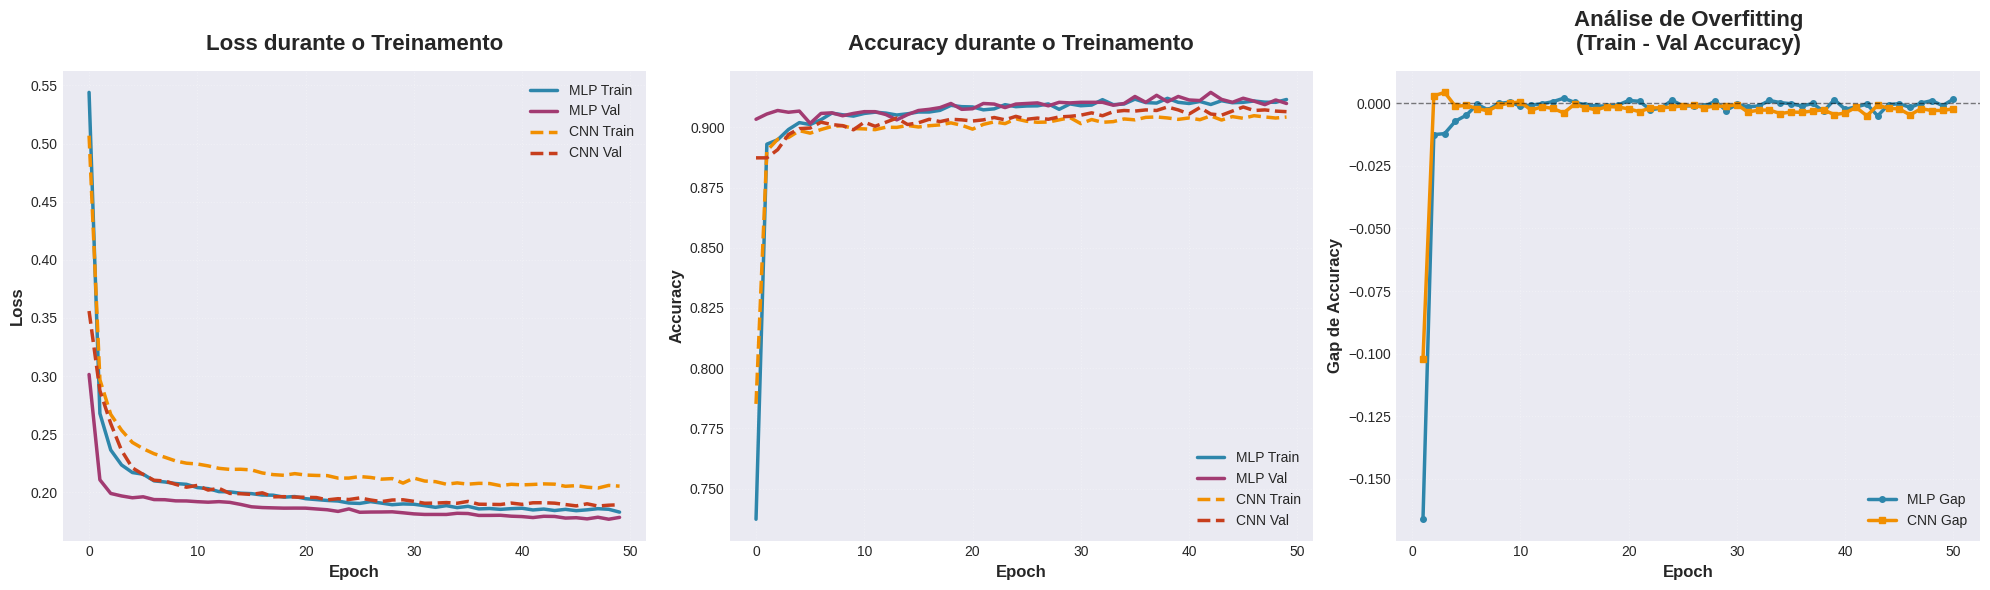

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
fig1 = plt.figure(figsize=(20, 6))

# 1. Curvas de Loss
ax1 = plt.subplot(1, 3, 1)
plt.plot(mlp_history.history['loss'], label='MLP Train', linewidth=2.5, color='#2E86AB')
plt.plot(mlp_history.history['val_loss'], label='MLP Val', linewidth=2.5, color='#A23B72')
plt.plot(cnn_history.history['loss'], label='CNN Train', linewidth=2.5, linestyle='--', color='#F18F01')
plt.plot(cnn_history.history['val_loss'], label='CNN Val', linewidth=2.5, linestyle='--', color='#C73E1D')
plt.title('Loss durante o Treinamento', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle=':')

# 2. Curvas de Accuracy
ax2 = plt.subplot(1, 3, 2)
plt.plot(mlp_history.history['accuracy'], label='MLP Train', linewidth=2.5, color='#2E86AB')
plt.plot(mlp_history.history['val_accuracy'], label='MLP Val', linewidth=2.5, color='#A23B72')
plt.plot(cnn_history.history['accuracy'], label='CNN Train', linewidth=2.5, linestyle='--', color='#F18F01')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val', linewidth=2.5, linestyle='--', color='#C73E1D')
plt.title('Accuracy durante o Treinamento', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle=':')

# 3. Overfitting Analysis
ax3 = plt.subplot(1, 3, 3)
mlp_gap = np.array(mlp_history.history['accuracy']) - np.array(mlp_history.history['val_accuracy'])
cnn_gap = np.array(cnn_history.history['accuracy']) - np.array(cnn_history.history['val_accuracy'])
epochs = range(1, len(mlp_gap) + 1)
plt.plot(epochs, mlp_gap, label='MLP Gap', linewidth=2.5, color='#2E86AB', marker='o', markersize=4)
plt.plot(epochs, cnn_gap, label='CNN Gap', linewidth=2.5, color='#F18F01', marker='s', markersize=4)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.title('Análise de Overfitting\n(Train - Val Accuracy)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Gap de Accuracy', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Métricas de treinamento salvas em 'training_metrics.png'")
plt.show()

#### Métricas de avaliação (Teste)

✓ Métricas de avaliação salvas em 'evaluation_metrics.png'


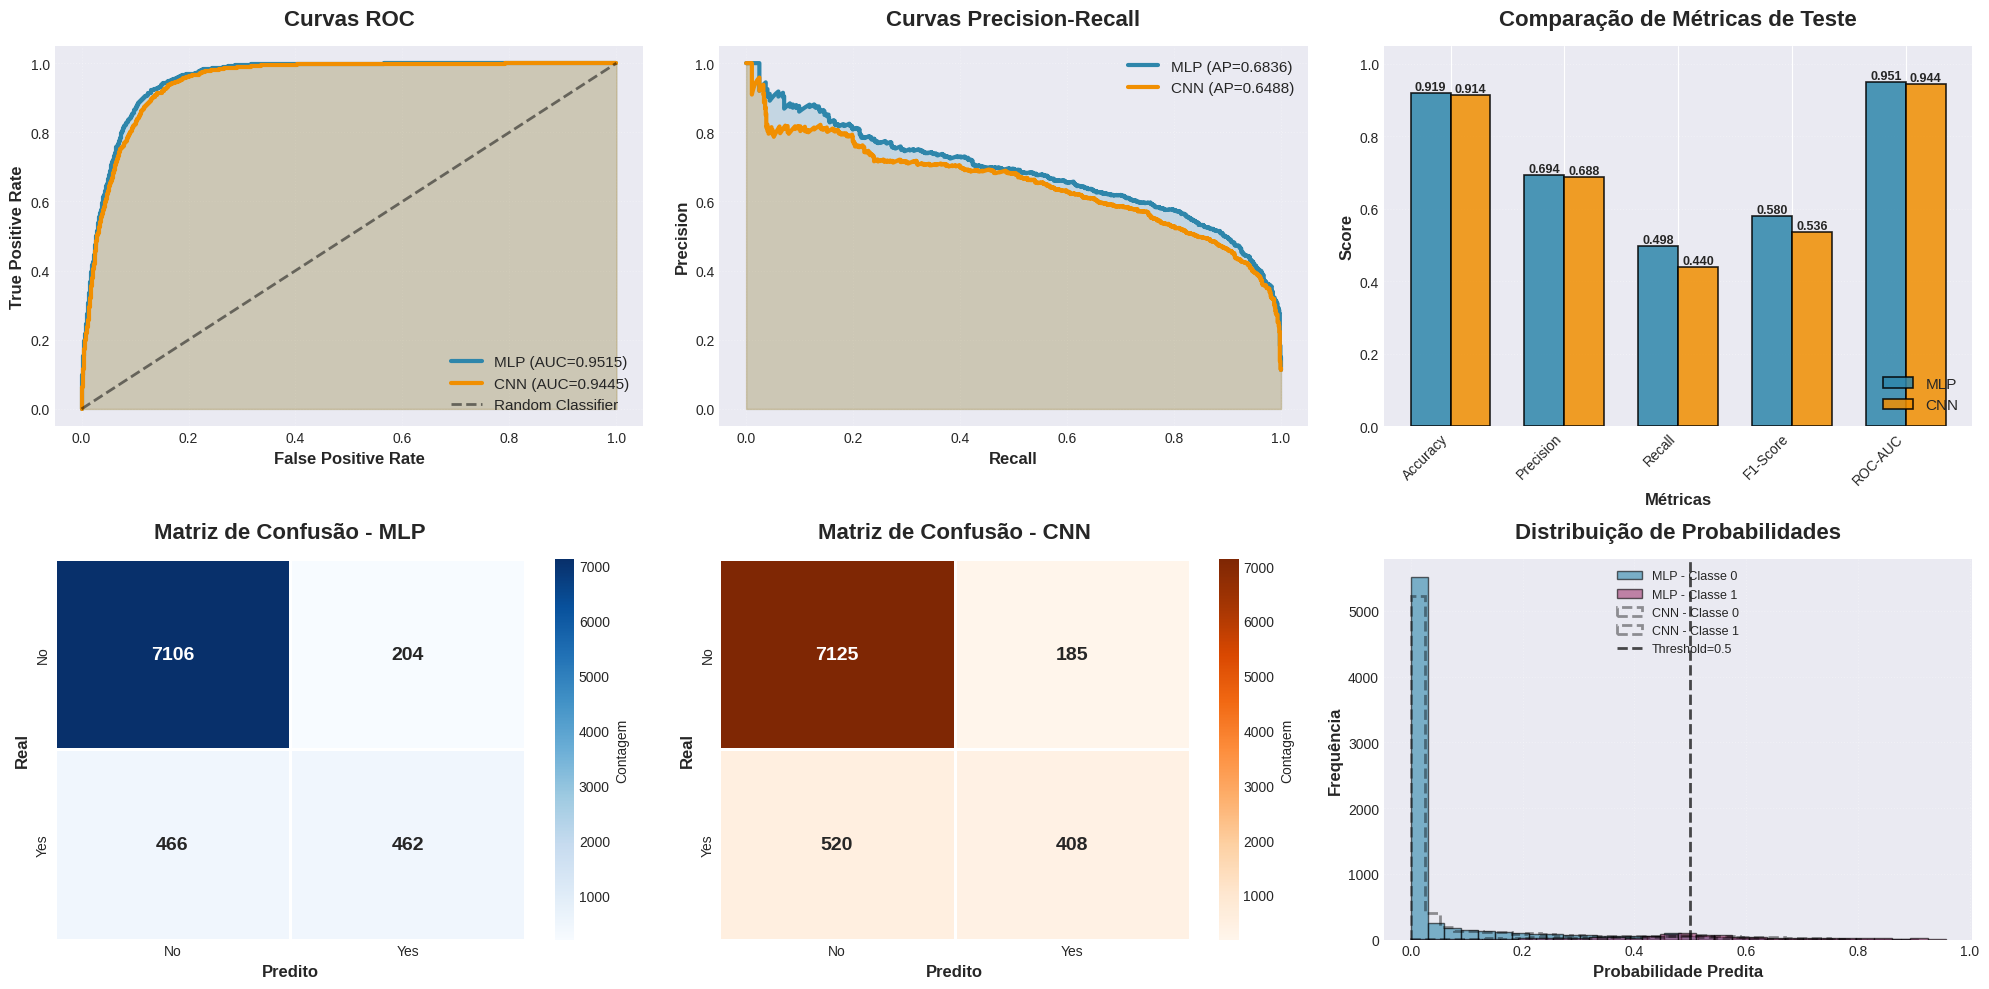


                          RESUMO DA ANÁLISE                           

MODELO          Accuracy     Precision    Recall       F1-Score     AUC       
----------------------------------------------------------------------
MLP             0.9187       0.6937       0.4978       0.5797       0.9515    
CNN             0.9144       0.6880       0.4397       0.5365       0.9445    


In [ ]:
fig2 = plt.figure(figsize=(20, 10))

# 1. ROC Curves
ax1 = plt.subplot(2, 3, 1)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_mlp_proba)
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_cnn_proba)
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC={mlp_metrics["auc"]:.4f})',
         linewidth=3, color='#2E86AB')
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC={cnn_metrics["auc"]:.4f})',
         linewidth=3, color='#F18F01')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2, alpha=0.5)
plt.fill_between(fpr_mlp, tpr_mlp, alpha=0.2, color='#2E86AB')
plt.fill_between(fpr_cnn, tpr_cnn, alpha=0.2, color='#F18F01')
plt.title('Curvas ROC', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle=':')

# 2. Precision-Recall Curves
ax2 = plt.subplot(2, 3, 2)
from sklearn.metrics import precision_recall_curve, average_precision_score
prec_mlp, rec_mlp, _ = precision_recall_curve(y_test, y_pred_mlp_proba)
prec_cnn, rec_cnn, _ = precision_recall_curve(y_test, y_pred_cnn_proba)
ap_mlp = average_precision_score(y_test, y_pred_mlp_proba)
ap_cnn = average_precision_score(y_test, y_pred_cnn_proba)
plt.plot(rec_mlp, prec_mlp, label=f'MLP (AP={ap_mlp:.4f})',
         linewidth=3, color='#2E86AB')
plt.plot(rec_cnn, prec_cnn, label=f'CNN (AP={ap_cnn:.4f})',
         linewidth=3, color='#F18F01')
plt.fill_between(rec_mlp, prec_mlp, alpha=0.2, color='#2E86AB')
plt.fill_between(rec_cnn, prec_cnn, alpha=0.2, color='#F18F01')
plt.title('Curvas Precision-Recall', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle=':')

# 3. Comparação de Métricas
ax3 = plt.subplot(2, 3, 3)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
mlp_values = [mlp_metrics['accuracy'], mlp_metrics['precision'],
              mlp_metrics['recall'], mlp_metrics['f1'], mlp_metrics['auc']]
cnn_values = [cnn_metrics['accuracy'], cnn_metrics['precision'],
              cnn_metrics['recall'], cnn_metrics['f1'], cnn_metrics['auc']]

x = np.arange(len(metrics_names))
width = 0.35
bars1 = plt.bar(x - width/2, mlp_values, width, label='MLP',
                alpha=0.85, color='#2E86AB', edgecolor='black', linewidth=1.2)
bars2 = plt.bar(x + width/2, cnn_values, width, label='CNN',
                alpha=0.85, color='#F18F01', edgecolor='black', linewidth=1.2)

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel('Métricas', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Comparação de Métricas de Teste', fontsize=16, fontweight='bold', pad=15)
plt.xticks(x, metrics_names, rotation=45, ha='right')
plt.legend(loc='lower right', fontsize=11, framealpha=0.9)
plt.ylim([0, 1.05])
plt.grid(True, alpha=0.3, axis='y', linestyle=':')

# 4. Matriz de Confusão MLP
ax4 = plt.subplot(2, 3, 4)
sns.heatmap(mlp_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            cbar_kws={'label': 'Contagem'}, annot_kws={'fontsize': 14, 'fontweight': 'bold'},
            linewidths=2, linecolor='white')
plt.title('Matriz de Confusão - MLP', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Real', fontsize=12, fontweight='bold')
plt.xlabel('Predito', fontsize=12, fontweight='bold')

# 5. Matriz de Confusão CNN
ax5 = plt.subplot(2, 3, 5)
sns.heatmap(cnn_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            cbar_kws={'label': 'Contagem'}, annot_kws={'fontsize': 14, 'fontweight': 'bold'},
            linewidths=2, linecolor='white')
plt.title('Matriz de Confusão - CNN', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Real', fontsize=12, fontweight='bold')
plt.xlabel('Predito', fontsize=12, fontweight='bold')

# 6. Distribuição de Probabilidades Preditas
ax6 = plt.subplot(2, 3, 6)
plt.hist(y_pred_mlp_proba[y_test == 0], bins=30, alpha=0.6, label='MLP - Classe 0',
         color='#2E86AB', edgecolor='black')
plt.hist(y_pred_mlp_proba[y_test == 1], bins=30, alpha=0.6, label='MLP - Classe 1',
         color='#A23B72', edgecolor='black')
plt.hist(y_pred_cnn_proba[y_test == 0], bins=30, alpha=0.4, label='CNN - Classe 0',
         color='#F18F01', edgecolor='black', linestyle='--', histtype='step', linewidth=2)
plt.hist(y_pred_cnn_proba[y_test == 1], bins=30, alpha=0.4, label='CNN - Classe 1',
         color='#C73E1D', edgecolor='black', linestyle='--', histtype='step', linewidth=2)
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2, alpha=0.7, label='Threshold=0.5')
plt.title('Distribuição de Probabilidades', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Probabilidade Predita', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.legend(loc='upper center', fontsize=9, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig('evaluation_metrics.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Métricas de avaliação salvas em 'evaluation_metrics.png'")
plt.show()

# Resumo final
print("\n" + "="*70)
print("RESUMO DA ANÁLISE".center(70))
print("="*70)
print(f"\n{'MODELO':<15} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'AUC':<10}")
print("-"*70)
print(f"{'MLP':<15} {mlp_metrics['accuracy']:<12.4f} {mlp_metrics['precision']:<12.4f} "
      f"{mlp_metrics['recall']:<12.4f} {mlp_metrics['f1']:<12.4f} {mlp_metrics['auc']:<10.4f}")
print(f"{'CNN':<15} {cnn_metrics['accuracy']:<12.4f} {cnn_metrics['precision']:<12.4f} "
      f"{cnn_metrics['recall']:<12.4f} {cnn_metrics['f1']:<12.4f} {cnn_metrics['auc']:<10.4f}")
print("="*70)

### Conclusão 🧾

In [ ]:

print(f"  - Dataset: {len(df)} registros com {len(df.columns)} features")
print(f"  - Modelos treinados: MLP e CNN 1D")
print(f"  - Métricas avaliadas: 5 (Accuracy, Precision, Recall, F1, AUC)")
print(f"  - Melhor modelo: {'MLP' if mlp_wins > cnn_wins else 'CNN' if cnn_wins > mlp_wins else 'Empate'}")
print(f"\nDesempenho do melhor modelo:")
best_metrics = mlp_metrics if mlp_wins > cnn_wins else cnn_metrics
print(f"  - Accuracy: {best_metrics['accuracy']:.4f}")
print(f"  - F1-Score: {best_metrics['f1']:.4f}")
print(f"  - ROC-AUC: {best_metrics['auc']:.4f}")


RESUMO DO PROJETO:
  - Dataset: 41188 registros com 21 features
  - Modelos treinados: MLP e CNN 1D
  - Métricas avaliadas: 5 (Accuracy, Precision, Recall, F1, AUC)
  - Melhor modelo: MLP

Desempenho do melhor modelo:
  - Accuracy: 0.9187
  - F1-Score: 0.5797
  - ROC-AUC: 0.9515
